In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import joblib

vs = {'renderer': 'png', 'width': 800, 'height': 400, 'scale': 2}

In [2]:
df = pd.read_csv('../data/pricerunner_aggregate.csv')
df.columns = df.columns.str.strip()  # Убираем пробелы в названиях столбцов
df.head(1)

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


# 1. Провести входной анализ данных (EDA)

In [3]:
df.info()  # Пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product ID      35311 non-null  int64 
 1   Product Title   35311 non-null  object
 2   Merchant ID     35311 non-null  int64 
 3   Cluster ID      35311 non-null  int64 
 4   Cluster Label   35311 non-null  object
 5   Category ID     35311 non-null  int64 
 6   Category Label  35311 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


In [4]:
df.nunique(dropna=False)  # Видим 10 классов. Product ID - уникальный идентификатор товара

Product ID        35311
Product Title     30993
Merchant ID         306
Cluster ID        13233
Cluster Label     12849
Category ID          10
Category Label       10
dtype: int64

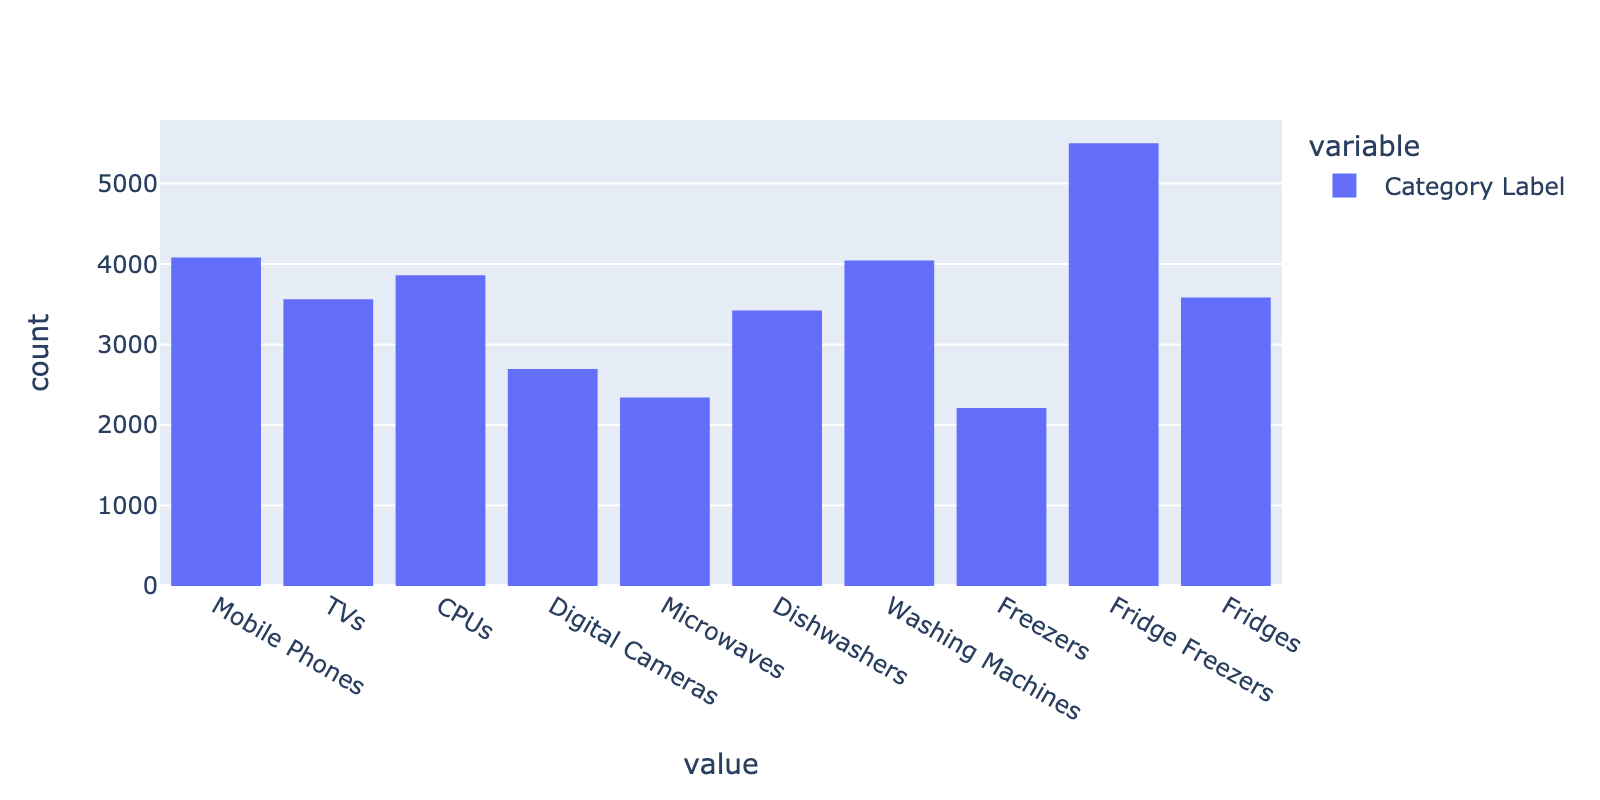

In [5]:
df['Category Label'].hist(backend='plotly').show(**vs)  # Распределение классов выглядит нормально 
# (Freezers - самый маленький класс, но понятно, обычно людям нужен холодильник вместе с морозильной камерой)

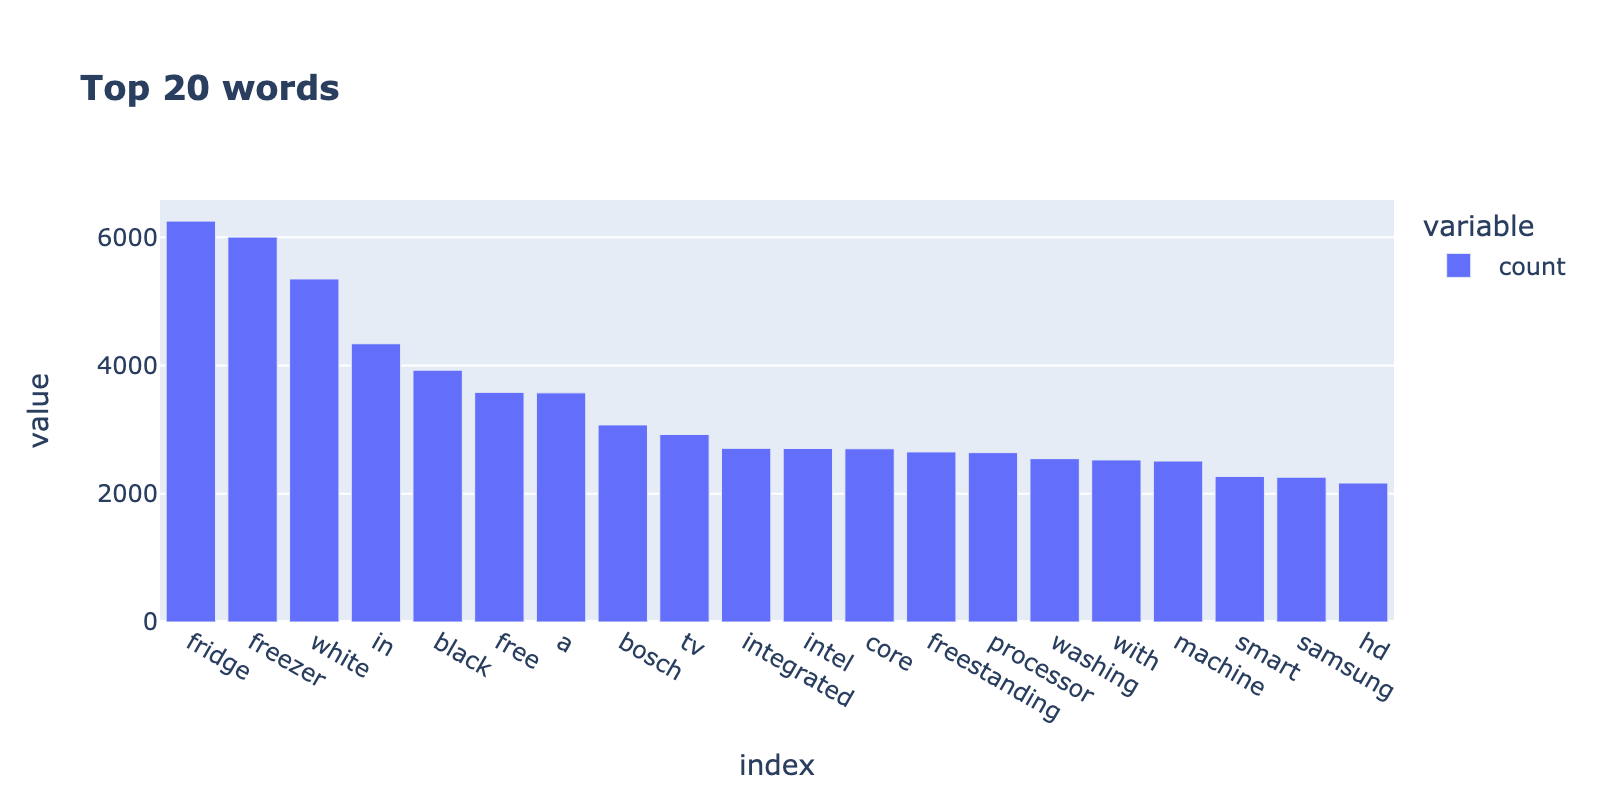

In [6]:
words_top = df['Product Title'].str.lower().str.split(' ', expand=True).stack().value_counts()
words_top[:20].plot.bar(backend='plotly', title='<b>Top 20 words').show(**vs)

In [7]:
words_top.shape  # Видим 21к уникальных слов

(21188,)

In [8]:
df[df['Product Title'].str.contains(words_top.tail(1).index[0])]

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
35305,47349,beko ra610w,341,47514,Beko RA610W White,2623,Fridges


# 2. Определить метрики для оценки эффективности модели

In [9]:
# Классы выглядят сбалансированными, поэтому будем использовать accuracy
df['Category Label'].value_counts(normalize=True)

Category Label
Fridge Freezers     0.155787
Mobile Phones       0.115573
Washing Machines    0.114525
CPUs                0.109371
Fridges             0.101498
TVs                 0.100932
Dishwashers         0.096967
Digital Cameras     0.076378
Microwaves          0.066325
Freezers            0.062643
Name: proportion, dtype: float64

# 3. Сформировть baseline-модель

In [10]:
# Попробуем обучить модель на TF-IDF векторах

tfidf_logreg = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1000))
])

x = df['Product Title'].str.lower()
y = df['Category Label']

scores = cross_val_score(tfidf_logreg, x, y, cv=5, scoring='accuracy')
print(f'Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

tfidf_logreg.fit(x, y)
print(f'Accuracy all data: {tfidf_logreg.score(x, y):.4f}')

Accuracy: 0.9434 ± 0.0231
Accuracy all data: 0.9888


In [11]:
# Посмотрим, где модель ошибается
y_pred = tfidf_logreg.predict(x)
df['Predicted Label'] = y_pred

df[df['Predicted Label'] != df['Category Label']][
    ['Product Title', 'Cluster Label', 'Category Label', 'Predicted Label']]

,Product Title,Cluster Label,Category Label,Predicted Label
1898,2 power 2p r1r9c notebook spare part display,Doro Liberto 825,Mobile Phones,TVs
4074,siemens sf65,Siemens SF65,Mobile Phones,Fridges
5843,silicon power computer communications inc sili...,Sony Bravia KD-55XE8596B,TVs,Mobile Phones
5988,canon eos 77d dslr camera memory card bag bundle,Samsung UE65MU7000,TVs,Digital Cameras
6453,fujifilm x pro2 mirrorless camera twin lens bu...,LG 60SJ850V,TVs,Digital Cameras
...,...,...,...,...
35266,samsung rfg23uers1 fridge freezer american sty...,Samsung RR82FERS1 Stainless Steel,Fridges,Fridge Freezers
35270,whirlpool arg 913/a fridge freezer,Whirlpool ARG913 White,Fridges,Fridge Freezers
35284,indesit intsz1612,Indesit INTSZ1611,Fridges,Washing Machines
35288,bosch kid28a21 fridge freezer,Bosch KIR18A21 White,Fridges,Fridge Freezers


In [12]:
# 5988 кейс. 
# Продукт: canon eos 77d dslr camera memory card bag bundle 
# Разметка из датасета: TVs
# Разметка моей моделью: Digital Cameras
# https://www.amazon.com/Canon-18-135mm-1892C002-Cleaning-Renewed/dp/B09L3HW6L6
# Это реально камера, а не телевизор
# Разметка содержит ошибки

# 4. Предложить улучшенную модель и вывести ее в продакшн

## Эксперименты

In [13]:
# Попробуем обучить модель не на TF-IDF векторах, а на count векторах
from sklearn.preprocessing import OneHotEncoder

count_logreg = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', LogisticRegression(max_iter=1000))
])

x = df['Product Title'].str.lower()
y = df['Category Label']

scores = cross_val_score(count_logreg, x, y, cv=5, scoring='accuracy')
print(f'Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

count_logreg.fit(x, y)
print(f'Accuracy all data: {count_logreg.score(x, y):.4f}')

Accuracy: 0.9422 ± 0.0228
Accuracy all data: 0.9937


In [14]:
# Попробуем дерево решений
from sklearn.tree import DecisionTreeClassifier

count_tree = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('model', DecisionTreeClassifier(min_samples_leaf=10))
])

x = df['Product Title'].str.lower()
y = df['Category Label']

scores = cross_val_score(count_tree, x, y, cv=5, scoring='accuracy')
print(f'Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

count_tree.fit(x, y)
print(f'Accuracy all data: {count_tree.score(x, y):.4f}')

Accuracy: 0.9111 ± 0.0387
Accuracy all data: 0.9306


In [15]:
# Попробуем случайный лес

count_forest = Pipeline([
    ('vectorizer', CountVectorizer(min_df=10)),
    ('model', RandomForestClassifier(n_estimators=500, min_samples_leaf=2, n_jobs=-1))
])

x = df['Product Title'].str.lower()
y = df['Category Label']

scores = cross_val_score(count_forest, x, y, cv=5, scoring='accuracy')
print(f'Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

count_forest.fit(x, y)
print(f'Accuracy all data: {count_forest.score(x, y):.4f}')

Accuracy: 0.9309 ± 0.0300
Accuracy all data: 0.9494


## Лучшая модель

In [16]:
# Улучшим count_logreg
count_logreg = Pipeline([
    ('vectorizer', CountVectorizer(min_df=20)),
    ('model', LogisticRegression(max_iter=1000))
])

x = df['Product Title'].str.lower() + ' ' + df['Cluster Label'].str.lower() + \
    ' Merchant_' + df['Merchant ID'].astype(str)
y = df['Category Label']

scores = cross_val_score(count_logreg, x, y, cv=5, scoring='accuracy')
print(f'Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

count_logreg.fit(x, y)
print(f'Accuracy all data: {count_logreg.score(x, y):.4f}')

Accuracy: 0.9515 ± 0.0216
Accuracy all data: 0.9704


# Соберем модель в продакшн

In [17]:
class ColumnConcater(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X['Product Title'].str.lower() + ' ' + X['Cluster Label'].str.lower() + \
            ' Merchant_' + X['Merchant ID'].astype(str)


prod_pipe = Pipeline([
    ('concat', ColumnConcater()),
    ('vectorizer', CountVectorizer(min_df=20)),
    ('model', LogisticRegression(max_iter=1000))
])

In [18]:
prod_pipe.fit(df, df['Category Label'])

print(f'Accuracy all data: {prod_pipe.score(df, df["Category Label"]):.4f}')

Accuracy all data: 0.9704


In [19]:
y_pred = prod_pipe.predict(df)
print(classification_report(df['Category Label'], y_pred))

                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00      3862
 Digital Cameras       1.00      1.00      1.00      2697
     Dishwashers       0.95      0.96      0.95      3424
        Freezers       0.97      0.92      0.94      2212
 Fridge Freezers       0.93      0.94      0.94      5501
         Fridges       0.92      0.92      0.92      3584
      Microwaves       0.98      0.97      0.98      2342
   Mobile Phones       1.00      1.00      1.00      4081
             TVs       0.99      1.00      0.99      3564
Washing Machines       0.99      0.99      0.99      4044

        accuracy                           0.97     35311
       macro avg       0.97      0.97      0.97     35311
    weighted avg       0.97      0.97      0.97     35311


In [20]:
# Видим, что модель получилась очень хорошей. Ошибки в классификации холодильника / морозильника / холодильника с морозильником 
# имхо, не критичны, так как это почти одинаковые товары, плюс разметка содержит некоторые ошибки

In [21]:
# Выведелем количество фичей в модели
coefs = pd.DataFrame({'names': prod_pipe['vectorizer'].get_feature_names_out(), 'coef': prod_pipe['model'].coef_[0]})
coefs['abs_coef'] = coefs['coef'].abs()

coefs.sort_values('abs_coef', ascending=False).head(20)

,names,coef,abs_coef
333,amd,2.517561,2.517561
730,intel,2.457403,2.457403
385,box,2.021490,2.021490
1248,tray,1.641637,1.641637
1353,xeon,1.115271,1.115271
453,core,1.089396,1.089396
1078,processor,1.071007,1.071007
641,ghz,0.836928,0.836928
1189,socket,0.649093,0.649093
697,hp,0.613070,0.613070


In [22]:
# Видим, что модель сильно опирается на бренд товара, также учитывает мерчанта и характеристики товара

In [23]:
# Сохраним модель
joblib.dump(prod_pipe, '../data/model__logreg__count_min_df_20_v1.joblib')

['../data/model__logreg__count_min_df_20_v1.joblib']

In [24]:
# Проверим, что нет проблем с загрузкой модели и расхождений в предсказаниях

In [25]:
prod_pipe_saved = joblib.load('../data/model__logreg__count_min_df_20_v1.joblib')
print(f'Accuracy all data: {prod_pipe_saved.score(df, df["Category Label"]):.4f}')

y_pred_saved = prod_pipe_saved.predict(df)
y_pred_trained = prod_pipe.predict(df)

print((y_pred_saved == y_pred_trained).all())

Accuracy all data: 0.9704
True
